In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO(conv_num=1):
    init_channel = 128
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/3))), 
                          strides=1, padding='same', activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 128)        768       
_________________________________________________________________
flatten (Flatten)            (None, 2048000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2048000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                32768016  
Total params: 32,768,784
Trainable params: 32,768,784
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (ty

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 5333, 128)         82048     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1777, 128)         0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1777, 64)          41024     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 592, 64)           0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0244 - acc: 0.3435
Epoch 00001: val_loss improved from inf to 1.56559, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_4_conv_checkpoint/001-1.5656.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 2.0243 - acc: 0.3435 - val_loss: 1.5656 - val_acc: 0.4945
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4330 - acc: 0.5528
Epoch 00002: val_loss improved from 1.56559 to 1.27141, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_4_conv_checkpoint/002-1.2714.hdf5
36805/36805 [==============================] - 108s 3ms/sample - loss: 1.4331 - acc: 0.5528 - val_loss: 1.2714 - val_acc: 0.6075
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2061 - acc: 0.6291
Epoch 00003: val_loss improved from 1.27141 to 1.16199, saving 

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1424 - acc: 0.9552
Epoch 00027: val_loss did not improve from 0.92722
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.1424 - acc: 0.9552 - val_loss: 1.1769 - val_acc: 0.7561
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1385 - acc: 0.9563
Epoch 00028: val_loss did not improve from 0.92722
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.1384 - acc: 0.9563 - val_loss: 1.2095 - val_acc: 0.7498
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1346 - acc: 0.9576
Epoch 00029: val_loss did not improve from 0.92722
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.1346 - acc: 0.9576 - val_loss: 1.2000 - val_acc: 0.7554
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1308 - acc: 0.9583
Epoch 00030: val_loss did not improve from 0.92722
36805/36805 [========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0728 - acc: 0.9788
Epoch 00057: val_loss did not improve from 0.92722
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0728 - acc: 0.9788 - val_loss: 1.3670 - val_acc: 0.7727
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0713 - acc: 0.9793
Epoch 00058: val_loss did not improve from 0.92722
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0713 - acc: 0.9793 - val_loss: 1.2955 - val_acc: 0.7750

1D_CNN_custom_4_ch_128_DO_4_conv Model


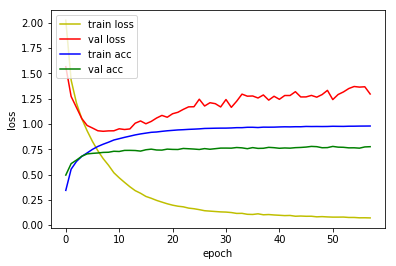

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.0248 - acc: 0.6814
Loss: 1.0247672792659495 Accuracy: 0.6814123

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1326 - acc: 0.3054
Epoch 00001: val_loss improved from inf to 1.60658, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_5_conv_checkpoint/001-1.6066.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 2.1325 - acc: 0.3054 - val_loss: 1.6066 - val_acc: 0.4778
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4911 - acc: 0.5205
Epoch 00002: val_loss improved from 1.60658 to 1.25247, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_5_conv_checkpoint/002-1.2525.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 1.4911 - acc: 0.5205 - val_loss: 1.2525 - val_acc: 0.6212
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss

36800/36805 [============================>.] - ETA: 0s - loss: 0.3341 - acc: 0.8952
Epoch 00024: val_loss did not improve from 0.63271
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.3344 - acc: 0.8952 - val_loss: 0.6698 - val_acc: 0.8293
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3290 - acc: 0.8949
Epoch 00025: val_loss did not improve from 0.63271
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.3289 - acc: 0.8949 - val_loss: 0.6410 - val_acc: 0.8300
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3127 - acc: 0.9010
Epoch 00026: val_loss did not improve from 0.63271
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.3127 - acc: 0.9010 - val_loss: 0.6596 - val_acc: 0.8260
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3044 - acc: 0.9035
Epoch 00027: val_loss did not improve from 0.63271
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1504 - acc: 0.9520
Epoch 00053: val_loss did not improve from 0.63209
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1505 - acc: 0.9520 - val_loss: 0.7520 - val_acc: 0.8388
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1514 - acc: 0.9512
Epoch 00054: val_loss did not improve from 0.63209
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1515 - acc: 0.9512 - val_loss: 0.7609 - val_acc: 0.8369
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1471 - acc: 0.9535
Epoch 00055: val_loss did not improve from 0.63209
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1472 - acc: 0.9534 - val_loss: 0.7470 - val_acc: 0.8493
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1446 - acc: 0.9529
Epoch 00056: val_loss did not improve from 0.63209
36805/36805 [=====================

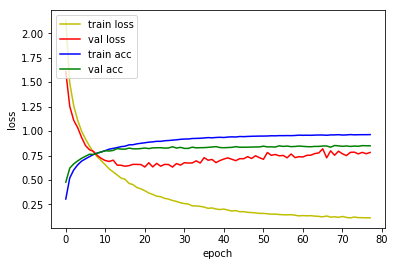

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.7509 - acc: 0.8012
Loss: 0.7508955137751927 Accuracy: 0.8012461

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3216 - acc: 0.2381
Epoch 00001: val_loss improved from inf to 1.70972, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_6_conv_checkpoint/001-1.7097.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 2.3215 - acc: 0.2381 - val_loss: 1.7097 - val_acc: 0.4484
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6335 - acc: 0.4657
Epoch 00002: val_loss improved from 1.70972 to 1.35060, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_6_conv_checkpoint/002-1.3506.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 1.6334 - acc: 0.4657 - val_loss: 1.3506 - val_acc: 0.5751
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3710 - acc: 0.8872
Epoch 00025: val_loss improved from 0.39402 to 0.38857, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_6_conv_checkpoint/025-0.3886.hdf5
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.3710 - acc: 0.8872 - val_loss: 0.3886 - val_acc: 0.8931
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3532 - acc: 0.8920
Epoch 00026: val_loss improved from 0.38857 to 0.38560, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_6_conv_checkpoint/026-0.3856.hdf5
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.3531 - acc: 0.8920 - val_loss: 0.3856 - val_acc: 0.8982
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3466 - acc: 0.8944
Epoch 00027: val_loss improved from 0.38560 to 0.37131, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_6_conv_checkpoint/027-0.3713.hdf5
3680

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1976 - acc: 0.9349
Epoch 00052: val_loss did not improve from 0.32396
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1976 - acc: 0.9349 - val_loss: 0.4051 - val_acc: 0.9068
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2011 - acc: 0.9347
Epoch 00053: val_loss did not improve from 0.32396
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.2011 - acc: 0.9347 - val_loss: 0.3488 - val_acc: 0.9152
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2010 - acc: 0.9337
Epoch 00054: val_loss did not improve from 0.32396
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.2010 - acc: 0.9337 - val_loss: 0.3488 - val_acc: 0.9154
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1956 - acc: 0.9362
Epoch 00055: val_loss did not improve from 0.32396
36805/36805 [========

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1334 - acc: 0.9547
Epoch 00082: val_loss did not improve from 0.32396
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1334 - acc: 0.9547 - val_loss: 0.3834 - val_acc: 0.9182
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1282 - acc: 0.9576
Epoch 00083: val_loss did not improve from 0.32396
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1282 - acc: 0.9576 - val_loss: 0.3735 - val_acc: 0.9201
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1327 - acc: 0.9549
Epoch 00084: val_loss did not improve from 0.32396
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1327 - acc: 0.9549 - val_loss: 0.3908 - val_acc: 0.9138
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1248 - acc: 0.9588
Epoch 00085: val_loss did not improve from 0.32396
36805/36805 [========

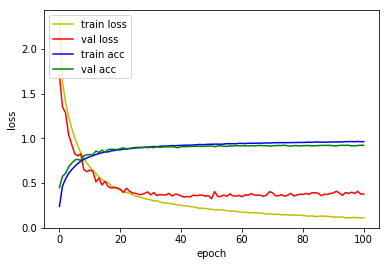

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3874 - acc: 0.8887
Loss: 0.38741967244806813 Accuracy: 0.88868123

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4703 - acc: 0.1862
Epoch 00001: val_loss improved from inf to 1.91755, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_7_conv_checkpoint/001-1.9175.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 2.4702 - acc: 0.1862 - val_loss: 1.9175 - val_acc: 0.4184
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8399 - acc: 0.3835
Epoch 00002: val_loss improved from 1.91755 to 1.44620, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_7_conv_checkpoint/002-1.4462.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 1.8400 - acc: 0.3835 - val_loss: 1.4462 - val_acc: 0.5628
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4605 - acc: 0.8587
Epoch 00023: val_loss did not improve from 0.33660
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.4604 - acc: 0.8587 - val_loss: 0.3380 - val_acc: 0.9124
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4493 - acc: 0.8611
Epoch 00024: val_loss improved from 0.33660 to 0.32986, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_7_conv_checkpoint/024-0.3299.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.4493 - acc: 0.8611 - val_loss: 0.3299 - val_acc: 0.9133
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4405 - acc: 0.8646
Epoch 00025: val_loss improved from 0.32986 to 0.32893, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_7_conv_checkpoint/025-0.3289.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.4405 - acc: 0.8646 - val_loss

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2815 - acc: 0.9102
Epoch 00049: val_loss improved from 0.21698 to 0.21517, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_7_conv_checkpoint/049-0.2152.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.2816 - acc: 0.9102 - val_loss: 0.2152 - val_acc: 0.9448
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2783 - acc: 0.9120
Epoch 00050: val_loss did not improve from 0.21517
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.2783 - acc: 0.9121 - val_loss: 0.2234 - val_acc: 0.9385
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2758 - acc: 0.9130
Epoch 00051: val_loss did not improve from 0.21517
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.2758 - acc: 0.9130 - val_loss: 0.2296 - val_acc: 0.9315
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - l

36800/36805 [============================>.] - ETA: 0s - loss: 0.2072 - acc: 0.9312
Epoch 00075: val_loss did not improve from 0.19808
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.2072 - acc: 0.9312 - val_loss: 0.2201 - val_acc: 0.9392
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2122 - acc: 0.9314
Epoch 00076: val_loss did not improve from 0.19808
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.2121 - acc: 0.9314 - val_loss: 0.2137 - val_acc: 0.9436
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2074 - acc: 0.9342
Epoch 00077: val_loss did not improve from 0.19808
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.2074 - acc: 0.9342 - val_loss: 0.2039 - val_acc: 0.9448
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2005 - acc: 0.9349
Epoch 00078: val_loss did not improve from 0.19808
36805/36805 [=====================

Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1634 - acc: 0.9460
Epoch 00104: val_loss did not improve from 0.19484
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1634 - acc: 0.9460 - val_loss: 0.1981 - val_acc: 0.9469
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1614 - acc: 0.9471
Epoch 00105: val_loss did not improve from 0.19484
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1615 - acc: 0.9471 - val_loss: 0.1988 - val_acc: 0.9453
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1639 - acc: 0.9449
Epoch 00106: val_loss did not improve from 0.19484
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1639 - acc: 0.9449 - val_loss: 0.2024 - val_acc: 0.9457
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1535 - acc: 0.9495
Epoch 00107: val_loss did not improve from 0.19484
36805/36805 [====

Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1307 - acc: 0.9555
Epoch 00134: val_loss did not improve from 0.19484
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1307 - acc: 0.9555 - val_loss: 0.2165 - val_acc: 0.9455
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1278 - acc: 0.9565
Epoch 00135: val_loss did not improve from 0.19484
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1278 - acc: 0.9566 - val_loss: 0.2228 - val_acc: 0.9495
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1290 - acc: 0.9572
Epoch 00136: val_loss did not improve from 0.19484
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1290 - acc: 0.9572 - val_loss: 0.1975 - val_acc: 0.9504
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1273 - acc: 0.9579
Epoch 00137: val_loss did not improve from 0.19484
36805/36805 [====

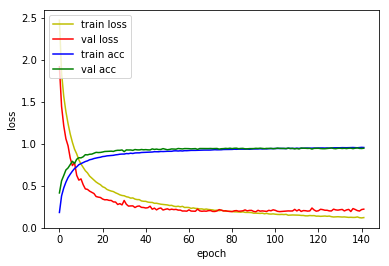

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2247 - acc: 0.9385
Loss: 0.22465223592327888 Accuracy: 0.93852544

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7047 - acc: 0.1000
Epoch 00001: val_loss improved from inf to 2.51716, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_8_conv_checkpoint/001-2.5172.hdf5
36805/36805 [==============================] - 113s 3ms/sample - loss: 2.7047 - acc: 0.1000 - val_loss: 2.5172 - val_acc: 0.2278
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2310 - acc: 0.2805
Epoch 00002: val_loss improved from 2.51716 to 1.70331, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_8_conv_checkpoint/002-1.7033.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 2.2309 - acc: 0.2805 - val_loss: 1.7033 - val_acc: 0.4689
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4466 - acc: 0.8619
Epoch 00024: val_loss did not improve from 0.27829
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.4466 - acc: 0.8619 - val_loss: 0.2785 - val_acc: 0.9213
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4361 - acc: 0.8650
Epoch 00025: val_loss improved from 0.27829 to 0.26409, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_8_conv_checkpoint/025-0.2641.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.4363 - acc: 0.8649 - val_loss: 0.2641 - val_acc: 0.9259
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4244 - acc: 0.8676
Epoch 00026: val_loss improved from 0.26409 to 0.25800, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_8_conv_checkpoint/026-0.2580.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.4245 - acc: 0.8675 - val_loss

36800/36805 [============================>.] - ETA: 0s - loss: 0.2704 - acc: 0.9140
Epoch 00049: val_loss improved from 0.18099 to 0.17656, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_8_conv_checkpoint/049-0.1766.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.2704 - acc: 0.9141 - val_loss: 0.1766 - val_acc: 0.9490
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2698 - acc: 0.9154
Epoch 00050: val_loss did not improve from 0.17656
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.2697 - acc: 0.9154 - val_loss: 0.1864 - val_acc: 0.9476
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2678 - acc: 0.9160
Epoch 00051: val_loss did not improve from 0.17656
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.2678 - acc: 0.9160 - val_loss: 0.1966 - val_acc: 0.9429
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2654 -

Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1951 - acc: 0.9363
Epoch 00077: val_loss did not improve from 0.16318
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1950 - acc: 0.9363 - val_loss: 0.1642 - val_acc: 0.9495
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1888 - acc: 0.9377
Epoch 00078: val_loss did not improve from 0.16318
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1888 - acc: 0.9378 - val_loss: 0.1785 - val_acc: 0.9492
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1888 - acc: 0.9385
Epoch 00079: val_loss did not improve from 0.16318
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1888 - acc: 0.9385 - val_loss: 0.1726 - val_acc: 0.9495
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1873 - acc: 0.9392
Epoch 00080: val_loss did not improve from 0.16318
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1413 - acc: 0.9537
Epoch 00106: val_loss did not improve from 0.16068
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1413 - acc: 0.9537 - val_loss: 0.1613 - val_acc: 0.9539
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1387 - acc: 0.9535
Epoch 00107: val_loss improved from 0.16068 to 0.15937, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_8_conv_checkpoint/107-0.1594.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1386 - acc: 0.9535 - val_loss: 0.1594 - val_acc: 0.9527
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1378 - acc: 0.9535
Epoch 00108: val_loss did not improve from 0.15937
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1378 - acc: 0.9535 - val_loss: 0.1722 - val_acc: 0.9518
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.139

36800/36805 [============================>.] - ETA: 0s - loss: 0.1126 - acc: 0.9619
Epoch 00135: val_loss did not improve from 0.15937
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1127 - acc: 0.9619 - val_loss: 0.1880 - val_acc: 0.9522
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1091 - acc: 0.9633
Epoch 00136: val_loss did not improve from 0.15937
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1091 - acc: 0.9633 - val_loss: 0.1941 - val_acc: 0.9506
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1058 - acc: 0.9632
Epoch 00137: val_loss did not improve from 0.15937
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1058 - acc: 0.9632 - val_loss: 0.2016 - val_acc: 0.9520
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1082 - acc: 0.9630
Epoch 00138: val_loss did not improve from 0.15937
36805/36805 [==================

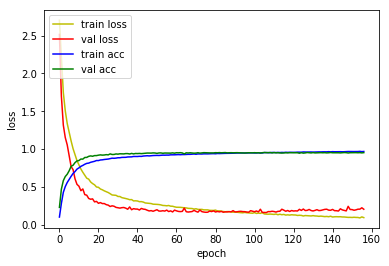

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2129 - acc: 0.9402
Loss: 0.212888934351852 Accuracy: 0.9401869

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5957 - acc: 0.1545
Epoch 00001: val_loss improved from inf to 1.98864, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_9_conv_checkpoint/001-1.9886.hdf5
36805/36805 [==============================] - 116s 3ms/sample - loss: 2.5957 - acc: 0.1545 - val_loss: 1.9886 - val_acc: 0.4435
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9199 - acc: 0.3824
Epoch 00002: val_loss improved from 1.98864 to 1.36057, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_9_conv_checkpoint/002-1.3606.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 1.9199 - acc: 0.3825 - val_loss: 1.3606 - val_acc: 0.5938
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4785 - acc: 0.8485
Epoch 00023: val_loss improved from 0.27060 to 0.25330, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_9_conv_checkpoint/023-0.2533.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.4786 - acc: 0.8484 - val_loss: 0.2533 - val_acc: 0.9241
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4710 - acc: 0.8499
Epoch 00024: val_loss did not improve from 0.25330
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.4710 - acc: 0.8499 - val_loss: 0.2612 - val_acc: 0.9196
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4605 - acc: 0.8531
Epoch 00025: val_loss did not improve from 0.25330
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.4605 - acc: 0.8531 - val_loss: 0.2775 - val_acc: 0.9138
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2641 - acc: 0.9141
Epoch 00049: val_loss improved from 0.19432 to 0.19283, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_9_conv_checkpoint/049-0.1928.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.2641 - acc: 0.9141 - val_loss: 0.1928 - val_acc: 0.9483
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2550 - acc: 0.9188
Epoch 00050: val_loss improved from 0.19283 to 0.18424, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_9_conv_checkpoint/050-0.1842.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.2550 - acc: 0.9188 - val_loss: 0.1842 - val_acc: 0.9432
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2538 - acc: 0.9174
Epoch 00051: val_loss improved from 0.18424 to 0.17686, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_9_conv_checkpoint/051-0.1769.hdf5
3680

36800/36805 [============================>.] - ETA: 0s - loss: 0.1671 - acc: 0.9440
Epoch 00077: val_loss did not improve from 0.16734
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1671 - acc: 0.9440 - val_loss: 0.1744 - val_acc: 0.9548
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1662 - acc: 0.9454
Epoch 00078: val_loss did not improve from 0.16734
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.1662 - acc: 0.9453 - val_loss: 0.1800 - val_acc: 0.9529
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1662 - acc: 0.9438
Epoch 00079: val_loss did not improve from 0.16734
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1662 - acc: 0.9438 - val_loss: 0.1802 - val_acc: 0.9522
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1559 - acc: 0.9470
Epoch 00080: val_loss did not improve from 0.16734
36805/36805 [=====================

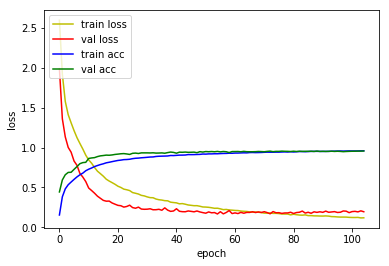

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2131 - acc: 0.9381
Loss: 0.21307669344473232 Accuracy: 0.93811005



In [10]:
for i in range(4, 10):
    base = '1D_CNN_custom_4_ch_128_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_4_ch_128_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_4_ch_128_DO_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5333, 128)         82048     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1777, 128)         0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 1777, 64)          41024     
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2247 - acc: 0.9385
Loss: 0.22465223592327888 Accuracy: 0.93852544

1D_CNN_custom_4_ch_128_DO_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 5333, 128)         82048     
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 1777, 128)         0         
_________________________________________________________________
conv1d_70 (Conv1D)           (Non

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_4_ch_128_DO_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5333, 128)         82048     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1777, 128)         0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 1777, 64)          41024     
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2406 - acc: 0.9335
Loss: 0.24061018266596154 Accuracy: 0.933541

1D_CNN_custom_4_ch_128_DO_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 5333, 128)         82048     
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 1777, 128)         0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None,